# PyTorch를 사용하여 GPU에서 심층 신경망 훈련

## 이 노트북에서 다룰 내용
1. 은닉층으로 심층 신경망 만들기
2. 비선형 활성화 함수 사용
3. GPU(사용 가능한 경우)를 사용하여 훈련 속도 향상
4. 모델 개선을 위한 하이퍼파라미터 실험

### 더 빠른 훈련을 위한 GPU 사용

실행 플랫폼이 NVIDIA에서 제조한 GPU에 연결된 경우 [그래픽 처리 장치](https://en.wikipedia.org/wiki/Graphics_processing_unit)(GPU)를 사용하여 모델을 더 빠르게 학습시킬 수 있다.

선택한 플랫폼에서 GPU를 사용하려면 다음 지침을 따르십시오.
* _Google Colab_: "Runtime > Change Runtime Type" 메뉴 옵션을 사용하고 "Hardware Accelerator" 드롭다운에서 "GPU"를 선택
* _Kaggle_: 사이드바의 "Settings" 섹션에 있는 "Accelerator" 드롭다운에서 "GPU"를 선택
* _Linux_: 노트북/데스크톱에 NVIDIA GPU(그래픽 카드)가 있는 경우 [NVIDIA CUDA 드라이버](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html)를 설치했는지 확인할 것
* _Windows_: 노트북/데스크톱에 NVIDIA GPU(그래픽 카드)가 있는 경우 [NVIDIA CUDA 드라이버](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html)를 설치했는지 확인할 것
* _macOS_: macOS는 NVIDIA GPU와 호환되지 않음

GPU에 액세스할 수 없거나 GPU가 무엇인지 확실하지 않더라도 걱정하지 마십시오. GPU 없이도 이 튜토리얼의 모든 코드를 실행할 수 있다.

## 데이터 준비

[이전 튜토리얼](https://jovian.ai/aakashns/03-logistic-regression)에서 우리는 MNIST 데이터 세트에서 약 86%의 정확도로 손으로 쓴 숫자를 식별하기 위해 로지스틱 회귀 모델을 훈련했다.

데이터 세트는 손으로 쓴 숫자(0~9)의 28픽셀 x 28픽셀 그레이스케일 이미지와 각 이미지가 나타내는 숫자를 나타내는 레이블로 구성된다.

다음은 데이터세트의 샘플 이미지다.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

모델이 픽셀 강도와 이미지 레이블 사이의 선형 관계를 가정하기 때문에 로지스틱 회귀 모델의 정확도를 87% 이상으로 향상시키는 것이 매우 어렵다는 것을 알았다.

이 게시물에서 우리는 입력과 목표 사이의 비선형 관계를 포착할 수 있는 *피드포워드 신경망*을 사용하여 이를 개선하려고 노력할 것이다.

`torch`, `torchvision`, `numpy` 및 `matplotlib`에서 필요한 모듈과 클래스를 설치하고 가져오는 것부터 시작하겠다.

In [3]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

데이터를 다운로드하고 `torchvision.datasets`의 `MNIST` 클래스를 사용하여 PyTorch 데이터 세트를 생성할 수 있다.

In [5]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

데이터 세트에서 몇 가지 이미지를 살펴보겠다. 이미지는 `1x28x28` 모양의 PyTorch 텐서로 변환된다(크기는 색상 채널, 너비 및 높이를 나타냄). `plt.imshow`를 사용하여 이미지를 표시할 수 있다. 그러나 `plt.imshow`는 채널이 이미지 텐서의 마지막 차원이 될 것으로 예상하므로 `permute` 방법을 사용하여 이미지의 차원을 재정렬한다.

image.shape: torch.Size([1, 28, 28])
Label: 5


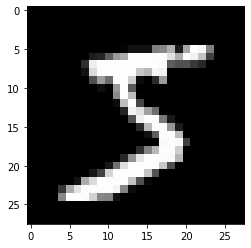

In [6]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


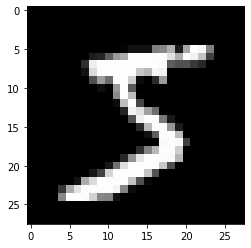

In [7]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

다음으로 `random_split` 헬퍼 함수를 사용하여 유효성 검사 세트를 위해 10000개의 이미지를 따로 설정해 보겠다.

In [8]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

이제 훈련 및 검증을 위한 PyTorch 데이터 로더를 생성할 수 있다.

In [9]:
batch_size=128

In [10]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

`num_workers`와 `pin_memory` 인수의 목적을 알 수 있습니까? 문서를 살펴보십시오: https://pytorch.org/docs/stable/data.html

`torchvision`의 `make_grid` 함수를 사용하여 그리드의 일괄 데이터를 시각화해 보겠다. 또한 텐서에서 `.permute` 메서드를 사용하여 `matplotlib`에서 예상한 대로 채널을 마지막 차원으로 이동한다.

images.shape: torch.Size([128, 1, 28, 28])


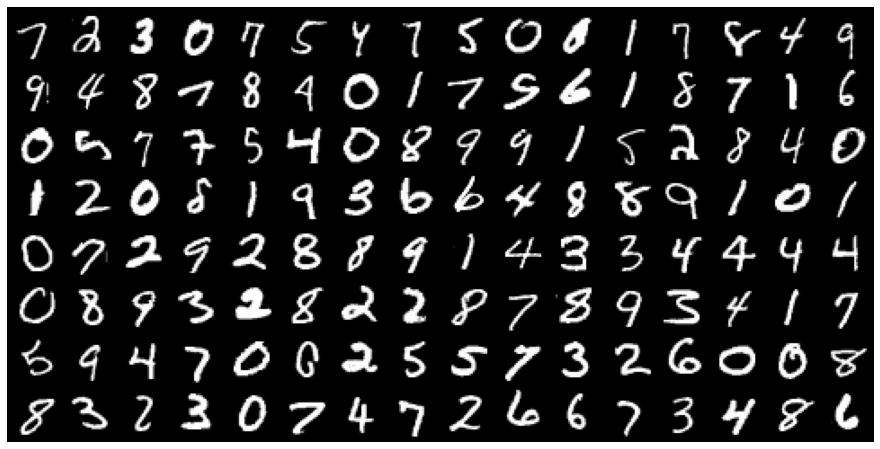

In [11]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## 은닉층, 활성화 함수 및 비선형성

_hidden layer_와 _output layer_라는 두 개의 레이어가 있는 신경망을 만들 것이다. 또한 두 레이어 사이에 _활성화 기능_을 사용할 것이다. 숨겨진 레이어와 활성화 함수가 입력과 출력 간의 비선형 관계를 캡처하는 데 어떻게 도움이 되는지 알아보기 위해 단계별 예제를 살펴보겠다.


먼저 입력 텐서 배치를 생성해 보겠다. `1x28x28` 이미지를 `784` 크기의 벡터로 병합하여 `nn.Linear` 객체에 전달할 수 있다.

In [12]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


다음으로 _hidden_ 레이어 역할을 할 `nn.Linear` 객체를 생성해 보겠다. 은닉층의 출력 크기를 32로 설정한다. 이 숫자는 모델의 _학습 능력_을 변경하기 위해 늘리거나 줄일 수 있다.

In [13]:
input_size = inputs.shape[-1]
hidden_size = 32

In [14]:
layer1 = nn.Linear(input_size, hidden_size)

이제 `layer1`을 통해 `inputs`를 전달하여 이미지 배치에 대한 중간 출력을 계산할 수 있다.

In [15]:
inputs.shape

torch.Size([128, 784])

In [16]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


크기 `784`의 이미지 벡터는 `layer1`의 전치된 가중치 행렬과 '입력' 행렬의 행렬 곱셈을 수행하고 바이어스를 추가하여 길이 `32`의 중간 출력 벡터로 변환된다.

`torch.allclose`를 사용하여 이를 확인할 수 있다.

자세한 설명은 [선형 회귀](https://jovian.ai/aakashns/02-linear-regression)에 대한 자습서를 검토해라.

In [17]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [18]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

따라서 `layer1_outputs`와 `inputs`는 선형 관계를 갖는다. 즉, `layer_outputs`의 각 요소는 `inputs`요소의 가중치 합이다.

따라서 모델을 훈련하고 가중치를 수정하더라도 `layer1`은 `입력`과 `출력` 간의 선형 관계만 캡처할 수 있다.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

다음으로, 출력에 대한 활성화 함수로 ReLU(Rectified Linear Unit) 함수를 사용할 것이다.

공식은 `relu(x) = max(0,x)`이다. 즉, 단순히 주어진 텐서의 음수 값을 값 0으로 바꾼다.

ReLU는 다음과 같이 시각적으로 볼 수 있는 비선형 함수다.

<img src="https://i.imgur.com/yijV4xF.png" width="420">

텐서의 요소에 ReLU를 적용하기 위해 `F.relu` 메소드를 사용할 수 있다.

In [19]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

`layer1_outputs`에 활성화 함수를 적용하고 음수 값이 0으로 대체되었는지 확인해보자.

In [20]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.9066599011421204
min(relu_outputs): 0.0


이제 비선형 활성화 함수를 적용했으므로 `relu_outputs`와 `inputs`에는 선형 관계가 없다.

각 입력에 대해 특정 출력(0이 아닌 값)이 활성화되고 다른 출력(0 값)은 꺼져 있기 때문에 `ReLU`를 _활성화 기능_이라고 한다.

다음으로 `relu_outputs`의 `hidden_size` 길이의 벡터를 우리 모델의 원하는 출력인 길이 10의 벡터로 변환하는 출력 레이어를 만들어 보겠다(10개의 레이블).

In [21]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [22]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [23]:
inputs.shape

torch.Size([128, 784])

예상대로 `layer2_outputs`에는 크기가 10인 벡터 배치가 포함되어 있다.

이제 이 출력을 사용하여 `F.cross_entropy`를 사용하여 손실을 계산하고 경사하강법을 사용하여 `layer1` 및 `layer2`의 가중치를 조정할 수 있다.

In [24]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3275, grad_fn=<NllLossBackward0>)

따라서 우리 모델은 선형 변환(`layer1` 사용)을 적용한 다음 비선형 활성화(`F.relu` 사용)를 적용한 다음 또 다른 선형 변환(`layer2` 사용)을 적용하여 `inputs`를 `layer2_outputs`로 변환한다.

기본 행렬 연산을 사용하여 출력을 다시 계산하여 이를 확인하자.

In [25]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [26]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

`출력`과 `입력`은 비선형 활성화 함수 `F.relu`로 인해 선형 관계가 아니다. 모델을 훈련하고 `Layer1`과 `layer2`의 가중치를 조정하면 이제 이미지와 레이블 간의 비선형 관계를 캡처할 수 있다. 다시 말해서, 비선형성을 도입하면 모델이 더 강력하고 다재다능해진다. 또한 `hidden_size`는 입력 또는 출력의 차원에 의존하지 않으므로 모델 내 매개변수의 수를 늘리기 위해 변경한다. 또한 새로운 은닉층을 도입하고 각 은닉층 다음에 동일한 비선형 활성화를 적용할 수 있다.


방금 만든 모델을 신경망이라고 한다.  _심층 신경망_은 단순히 하나 이상의 은닉층이 있는 신경망이다. 실제로 [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html)은 충분히 크고 깊은 신경망이 임의의 함수, 즉 입력과 대상 간의 풍부하고 복잡한 비선형 관계를 _학습_할 수 있다. 

여기 몇 가지 예시가 있다:
* 이미지에 고양이 또는 개가 포함되어 있는지 식별(또는 [다른 것](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* 10초 샘플을 사용하여 노래의 장르 식별
* 내용에 따라 영화 리뷰를 긍정적 또는 부정적으로 분류
* 도로의 비디오 피드를 사용하여 자율 주행 자동차 탐색
* 영어에서 프랑스어(및 수백 가지 다른 언어)로 문장 번역
* 음성 녹음을 텍스트로 또는 그 반대로 변환

무작위로 초기화된 행렬로 입력을 곱하고, 비선형 활성화를 적용하고, 경사하강법을 사용하여 반복적으로 가중치를 조정하는 간단한 프로세스가 어떻게 그러한 놀라운 결과를 얻을 수 있는지 상상하기 어렵다. 딥 러닝 모델에는 종종 인간의 두뇌가 이해할 수 있는 것보다 훨씬 더 복잡한 관계를 캡처할 수 있는 수백만 개의 매개변수가 포함된다.

두 선형 레이어 사이에 비선형 활성화를 포함하지 않았다면 입력과 출력 사이의 최종 관계는 여전히 선형이다. 계산의 간단한 리팩토링이 이를 보여준다.

In [27]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [28]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [29]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [30]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## 모델

이제 모델을 정의할 준비가 되었다. 위에서 논의한 바와 같이, 우리는 하나의 은닉층이 있는 신경망을 생성할 것입니다. 이것이 의미하는 바는 다음과 같다.

* 단일 `nn.Linear` 객체를 사용하여 일괄 입력(픽셀 강도)을 출력(클래스 확률)으로 변환하는 대신 두 개의 `nn.Linear` 객체를 사용한다. 이들 각각을 네트워크에서 _layer_라고 한다.

* 첫 번째 레이어(히든 레이어라고도 함)는 `batch_size x 784` 모양의 입력 행렬을 `batch_size x hidden_size` 모양의 중간 출력 행렬로 변환한다. `hidden_size` 매개변수는 수동으로 구성할 수 있다(예: 32 또는 64).

* 그런 다음 중간 출력에 비선형 *활성화 함수*를 적용한다. 활성화 함수는 행렬의 개별 요소를 변환한다.

* 크기가 `batch_size x hidden_size`인 활성화 함수의 결과는 두 번째 계층(출력 계층이라고도 함)으로 전달한다. 두 번째 레이어는 `batch_size x 10` 크기의 행렬로 변환한다. 이 출력을 사용하여 손실을 계산하고 경사하강법을 사용하여 가중치를 조정할 수 있다.


위에서 논의한 바와 같이 우리 모델은 하나의 은닉층을 포함할 것이다. 시각적으로 보이는 것은 다음과 같다.

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


PyTorch에서 `nn.Module` 클래스를 확장하여 모델을 정의해 보겠다.

In [31]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

또한 일괄 입력에 대한 모델 예측의 정확도를 계산하는 `정확도` 함수를 정의해야 한다. 

위의 `validation_step`에서 사용된다.

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

32개의 활성화가 있는 은닉층을 포함하는 모델을 생성한다.

In [33]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [34]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

모델의 매개변수를 살펴보겠다. 각 레이어에 대해 하나의 가중치 및 편향 행렬이 표시될 것으로 예상한다.

In [35]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


모델을 사용하여 일부 출력을 생성해 보겠다.

데이터 세트에서 128개 이미지의 첫 번째 배치를 가져와서 모델에 전달한다.

In [36]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3166871070861816
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0822, -0.2145,  0.0727, -0.1671,  0.2527, -0.0482,  0.0227, -0.1171,
         -0.1853, -0.1225],
        [ 0.0390, -0.1611,  0.1688, -0.1446,  0.1810, -0.0219, -0.1117, -0.0244,
         -0.1203, -0.0229]])


## GPU 사용

모델 및 데이터 세트의 크기가 증가함에 따라 GPU를 사용하여 합리적인 시간 내에 모델을 교육해야 한다.

GPU에는 부동 소수점 숫자에 대해 값비싼 행렬 연산을 빠르게 수행하도록 최적화된 수백 개의 코어가 포함되어 있어 심층 신경망 훈련에 이상적이다.

[Google Colab](https://colab.research.google.com/) 및 [Kaggle](https://www.kaggle.com/kernels)에서 GPU를 무료로 사용하거나 서비스에서 GPU 기반 머신을 대여할 수 있다. [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), 및 [페이퍼스페이스](https://www.paperspace.com/).

GPU를 사용할 수 있고 필요한 NVIDIA CUDA 드라이버가 `torch.cuda.is_available`을 사용하여 설치되었는지 확인할 수 있다.

In [37]:
torch.cuda.is_available()

True

사용 가능한 경우 코드가 GPU를 사용하고 그렇지 않은 경우 기본적으로 CPU를 사용하도록 도우미 함수를 정의해 보겠다.

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [41]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


마지막으로 `DeviceDataLoader` 클래스를 정의하여 기존 데이터 로더를 래핑하고 데이터 배치를 선택한 장치로 이동시킨다.

흥미롭게도 PyTorch 데이터 로드를 생성하기 위해 기존 클래스를 확장할 필요가 없다.

우리에게 필요한 것은 데이터 배치를 검색하는 `__iter__` 메소드와 배치 수를 가져오는 `__len__` 메소드뿐이다.

In [42]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Python의 `yield` 키워드는 아래 그림과 같이 `for` 루프 내에서 사용할 수 있는 생성기 함수를 만드는 데 사용된다.

In [43]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


이제 `DeviceDataLoader`를 사용하여 데이터 로더를 래핑할 수 있다.

In [44]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

GPU로 이동된 텐서에는 `cuda`라는 단어가 포함된 `device` 속성이 있다.

`valid_dl`의 데이터 배치를 보고 이를 확인합시다.

In [46]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([8, 0, 8, 8, 2, 1, 9, 7, 3, 4, 5, 3, 4, 6, 7, 1, 0, 1, 3, 4, 6, 8, 7, 3,
        2, 9, 8, 1, 3, 1, 6, 8, 5, 0, 0, 8, 4, 9, 6, 5, 3, 5, 6, 2, 5, 1, 8, 4,
        3, 4, 8, 7, 4, 7, 0, 9, 6, 7, 3, 1, 5, 6, 7, 8, 3, 5, 0, 3, 3, 3, 9, 1,
        8, 8, 2, 3, 1, 1, 1, 3, 3, 1, 9, 5, 9, 7, 4, 2, 8, 0, 8, 6, 0, 7, 5, 1,
        3, 4, 5, 6, 3, 7, 1, 8, 4, 3, 4, 4, 7, 8, 3, 6, 6, 8, 0, 6, 0, 8, 6, 9,
        3, 2, 9, 1, 0, 1, 1, 2, 3, 2, 8, 8, 2, 5, 2, 3, 8, 5, 6, 9, 0, 0, 2, 1,
        9, 0, 9, 2, 4, 4, 4, 1, 7, 7, 6, 6, 0, 0, 7, 8, 5, 6, 1, 6, 1, 8, 7, 6,
        1, 1, 3, 3, 7, 1, 6, 3, 2, 5, 8, 8, 5, 8, 3, 9, 5, 1, 4, 0, 6, 1, 3, 5,
        6, 9, 2, 6, 0, 0, 2, 3, 1, 4, 5, 4, 1, 3, 9, 3, 6, 2, 7, 3, 7, 7, 5, 7,
        0, 9, 4, 8, 0, 7, 5, 1, 0, 7, 8, 6, 5, 4, 9, 1, 8, 3, 8, 6, 3, 9, 6, 4,
        9, 1, 2, 1, 2, 6, 0, 7, 3, 2, 6, 5, 3, 0, 5, 7], device='cuda:0')


## 모델 훈련

기울기 하강법을 사용하여 모델을 훈련하고 검증 세트에서 성능을 평가하기 위해 `fit` 및 `evaluate`라는 두 가지 함수를 정의한다.

이러한 기능에 대한 자세한 설명은 [이전 튜토리얼](https://jovian.ai/aakashns/03-logistic-regression)을 확인할 것.

In [47]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

모델을 훈련하기 전에 데이터와 모델의 매개변수(가중치 및 편향)가 동일한 장치(CPU 또는 GPU)에 있는지 확인해야 한다.

모델의 매개변수를 올바른 장치로 이동하기 위해 `to_device` 함수를 재사용할 수 있다.

In [48]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

초기 가중치 및 편향 세트를 사용하여 검증 세트에서 모델이 어떻게 수행되는지 보자.

In [49]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3171067237854004, 'val_acc': 0.09580077975988388}]

무작위로 초기화된 모델에서 예상할 수 있듯이 초기 정확도는 약 10%다(무작위로 추측하여 올바른 레이블을 얻을 확률이 10분의 1이기 때문).

5개의 Epoch 동안 모델을 훈련시키고 결과를 살펴보겠습니다. 0.5라는 비교적 높은 학습률을 사용할 수 있다.

In [50]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2318, val_acc: 0.9317
Epoch [1], val_loss: 0.1792, val_acc: 0.9481
Epoch [2], val_loss: 0.1532, val_acc: 0.9561
Epoch [3], val_loss: 0.1377, val_acc: 0.9602
Epoch [4], val_loss: 0.1299, val_acc: 0.9627


96%는 꽤 좋습니다! 정확도를 더욱 향상시키기 위해 0.1의 낮은 학습률에서 5개의 에포크를 더 훈련해 보겠다.

In [51]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1184, val_acc: 0.9659
Epoch [1], val_loss: 0.1166, val_acc: 0.9669
Epoch [2], val_loss: 0.1156, val_acc: 0.9669
Epoch [3], val_loss: 0.1144, val_acc: 0.9659
Epoch [4], val_loss: 0.1134, val_acc: 0.9673


이제 시간이 지남에 따라 모델이 어떻게 개선되는지 연구하기 위해 손실 및 정확도를 플롯할 수 있다.

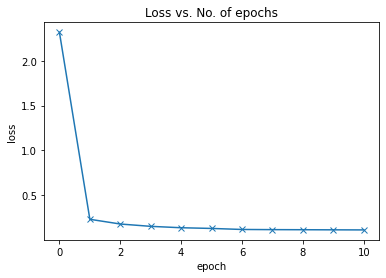

In [52]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

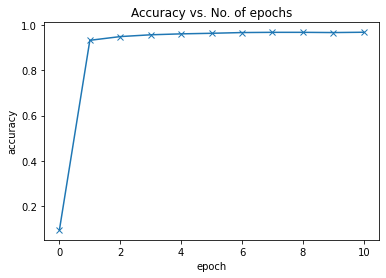

In [53]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

우리의 현재 모델은 로지스틱 회귀 모델(약 86%의 정확도만 달성할 수 있음)보다 상당한 차이로 성능이 뛰어납니다! 97%의 정확도에 빠르게 도달하지만 이 이상으로 개선되지는 않는다.

정확도를 더 높이려면 은닉층의 크기를 늘리거나 활성화를 통해 은닉층을 더 추가하여 모델을 더 강력하게 만들어야 한다.

이 두 가지 접근 방식을 모두 시도해 보고 어느 것이 더 효과적인지 확인하는 것이 좋다.

## 개별 이미지로 테스트

지금까지 모델의 전체 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 확인하는 것도 좋은 생각이다.

미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠다.

`ToTensor` 변환을 사용하여 테스트 데이터 세트를 다시 만드는 것으로 시작한다.

In [54]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

단일 이미지 텐서에 대해 예측된 레이블을 반환하는 도우미 함수 `predict_image`를 정의해 보겠다.

In [55]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

몇 가지 이미지로 시도해 보겠습니다.

Label: 7 , Predicted: 7


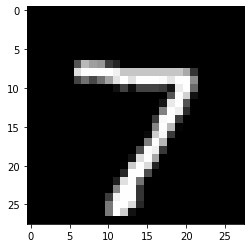

In [56]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


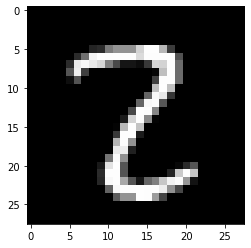

In [57]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


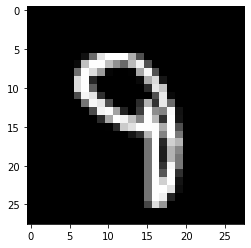

In [58]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델 성능이 저조한 위치를 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있다.

마지막 단계로 테스트 세트에서 모델의 전체 손실과 정확도도 살펴보겠다.

In [59]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10802159458398819, 'val_acc': 0.967968761920929}

검증 세트의 정확도/손실과 유사할 것으로 예상된다.

그렇지 않은 경우 테스트 세트(종종 실제 데이터에서 가져옴)와 유사한 데이터 및 분포를 가진 더 나은 검증 세트가 필요할 수 있다.